In [1]:
# Risk Returns Analysis

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from datetime import date
from tabulate import tabulate
from nsepy import get_history as gh

[*********************100%%**********************]  1 of 1 completed


An exception occurred while executing var_weighted_decay_factor: 'Stock'
The Bootstrap VaR measure is -0.049898257921170114
The VAR of stock using decay factor is -0.026165917565870524 
The mean Monte Carlo VaR is -0.05353951773886981
An exception occurred while executing var_weighted_decay_factor: 'Stock'
The Bootstrap VaR measure is -0.050342112074860765
The VAR of stock using decay factor is -0.026165917565870524 
The mean Monte Carlo VaR is -0.05333714030020228
╒════════════╤══════════════╤═════════════╤═════════╤═══════════════╕
│            │  Historical  │  Bootstrap  │  Decay  │  Monte Carlo  │
╞════════════╪══════════════╪═════════════╪═════════╪═══════════════╡
│ ['FCL.NS'] │              │   -0.0503   │ -0.0262 │    -0.0533    │
╘════════════╧══════════════╧═════════════╧═════════╧═══════════════╛
An exception occurred while executing var_weighted_decay_factor: 'Stock'
The Bootstrap VaR measure is -0.04964594050977943
The VAR of stock using decay factor is -0.026165917565870

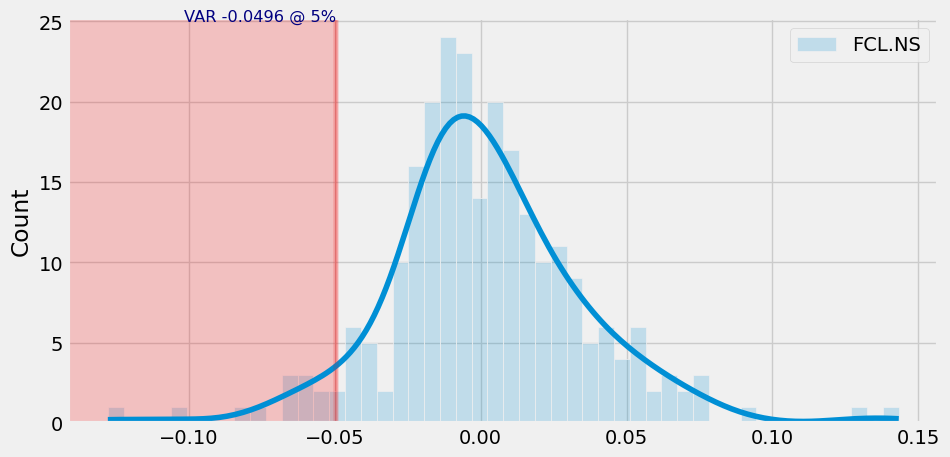

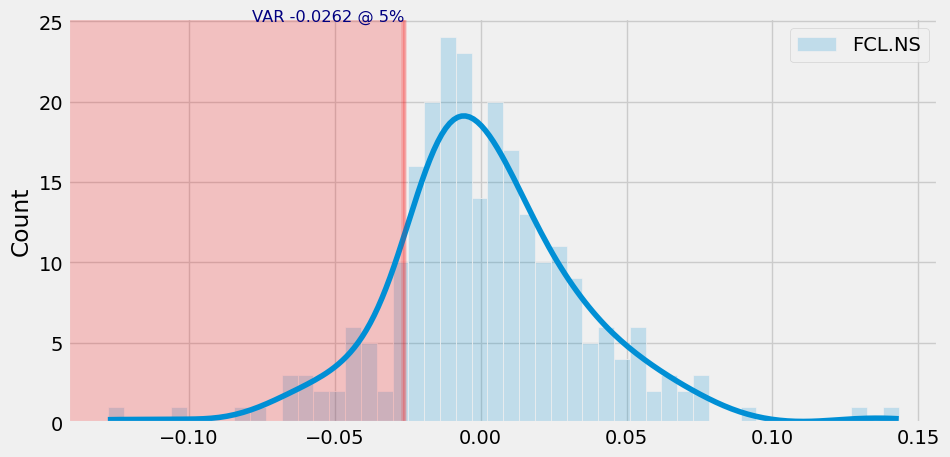

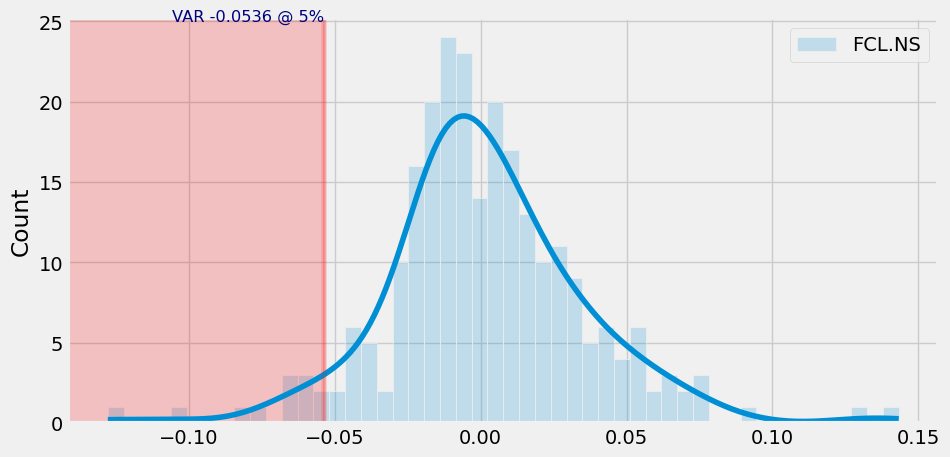

In [24]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
import seaborn as sns
from datetime import date
from tabulate import tabulate
import yfinance as yf  # Updated import

plt.style.use('fivethirtyeight')  # Setting matplotlib style
warnings.filterwarnings('ignore')

##################################################################
# Define configurations
##################################################################
initial_investment: int = 100000
startdate = date(2022, 2, 2)
end_date = date(2023, 2, 2)
stocksymbols = ['FCL.NS']
iterations: int = 1000


class LoadData:
    def __init__(self, start_date, end_date, ticker):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker
        self.df_stock_data = self.load_stock_data()
        self.df_returns = self.calculate_returns()

    def load_stock_data(self):
        df = pd.DataFrame()
        for stock_symbol in self.ticker:
            data = yf.download(stock_symbol, start=self.start_date, end=self.end_date)[['Close']]
            data.rename(columns={'Close': stock_symbol}, inplace=True)
            if df.empty:
                df = data
            else:
                df = df.join(data)
        return df

    def calculate_returns(self):
        df_returns = self.df_stock_data.pct_change()
        df_returns.dropna(inplace=True)
        return df_returns


class StockRisk:
    def __init__(self, start_date, end_date, investment: int, ticker: str, iterations: int):
        self.start_date = start_date
        self.end_date = end_date
        self.investment = investment
        self.ticker = ticker
        self.iterations = iterations

        # Create an instance of the data load class
        self.obj_loadData = LoadData(start_date, end_date, ticker)
        # Access df_returns through obj_loadData
        self.df_returns = self.obj_loadData.df_returns

    def var_historical(self):
        try:
            # returns = df_returns.copy()
            returns = self.obj_loadData.df_returns.copy()
            # check for variance
            var_stock = returns.var()

            # Calculate mean returns of the stock
            avg_rets = returns.mean()

            # Calculate SD of the stock
            avg_std = returns.std()

            returns['Stock'].mean()
            returns['Stock'].median()
            returns['Stock'].quantile(.05, 'lower')
            # var_hist = returns['Stock'].quantile(.05, 'lower')
            returns.sort_values('Stock').head(13)
            var_hist = np.percentile(returns['Stock'], 5, interpolation='lower')

            print(tabulate([[self.ticker, avg_rets, avg_std, var_hist]],
                            headers=['Mean', 'Standard Deviation', 'VaR %'],
                            tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".4f"))
            print(var_hist)
            return var_hist
        except Exception as e:
            print(f'An exception occurred while executing var_weighted_decay_factor: {e}')

    def var_bootstrap(self):
        """Bootstrap

        Args:
            iterations (int): The number of times the resampling is carried out 
        """
        def var_boot(data):
            dff = pd.DataFrame(data, columns=['sample'])
            return np.percentile(dff, 5, interpolation='lower')

        def bootstrap(data, func):
            sample = np.random.choice(data, len(data))
            return func(sample)

        def generate_sample_data(data, func, size):
            bs_replicates = np.empty(size)
            for i in range(size):
                bs_replicates[i] = bootstrap(data, func)
            return bs_replicates

        returns = self.obj_loadData.df_returns.copy()

        bootstrap_VaR = generate_sample_data(returns[self.ticker[0]], var_boot, self.iterations)
        var_bootstrap = np.mean(bootstrap_VaR)
        print(f'The Bootstrap VaR measure is {var_bootstrap}')
        return var_bootstrap

    def var_weighted_decay_factor(self):
        try:
            returns = self.obj_loadData.df_returns.copy()
            decay_factor = 0.5  # we’re picking this arbitrarily
            n = len(returns)
            wts = [(decay_factor**(i-1) * (1-decay_factor))/(1-decay_factor**n) for i in range(1, n+1)]
    
            # Need to reverse the PnL to put recent returns on top
            returns_recent_first = returns[::-1]
            weights_dict = {'Returns': returns_recent_first, 'Weights': wts}
    
            wts_returns = pd.DataFrame(returns_recent_first[self.ticker[0]])
            wts_returns['wts'] = wts
    
            sort_wts = wts_returns.sort_values(by=self.ticker[0])
            sort_wts['Cumulative'] = sort_wts.wts.cumsum()
    
            # Find where cumulative (percentile) hits 0.05
            sort_wts = sort_wts.reset_index()
            idx = sort_wts[sort_wts.Cumulative <= 0.05][self.ticker[0]].idxmax()
            sort_wts.filter(items=[idx], axis=0)
    
            xp = sort_wts.loc[idx:idx+1, 'Cumulative'].values
            fp = sort_wts.loc[idx:idx+1, self.ticker[0]].values
            var_decay = np.interp(0.05, xp, fp)
    
            print(f'The VAR of stock using decay factor is {var_decay} ')
            return var_decay
        except Exception as e:
            print(f'An exception occurred while executing var_weighted_decay_factor: {e}')
            return None  # Return a default value if an exception occurs


    def var_monte_carlo(self):
        try:
            returns = self.obj_loadData.df_returns.copy()
            returns_mean = returns[self.ticker[0]].mean()
            returns_sd = returns[self.ticker[0]].std()

            def simulate_values(mu, sigma):
                try:
                    result = []
                    for i in range(self.iterations):
                        tmp_val = np.random.normal(mu, sigma, (len(returns)))
                        var_MC = np.percentile(tmp_val, 5, interpolation='lower')
                        result.append(var_MC)
                    return result
                except Exception as e:
                    print(f'An exception occurred while generating simulation values: {e}')

            sim_val = simulate_values(returns_mean, returns_sd)

            tmp_df = pd.DataFrame(columns=['Iteration', 'VaR'])
            tmp_df['Iteration'] = [i for i in range(1, self.iterations + 1)]
            tmp_df['VaR'] = sim_val

            VaR_MC = statistics.mean(sim_val)

            print(f'The mean Monte Carlo VaR is {VaR_MC}')

            return VaR_MC
        except Exception as e:
            print(f'An exception occurred while executing var_monte_carlo: {e}')

    def show_summary(self):
        try:
            var_hist = self.var_historical()
            var_bs = self.var_bootstrap()
            var_decay = self.var_weighted_decay_factor()
            var_MC = self.var_monte_carlo()

            print(tabulate([[self.ticker, var_hist, var_bs, var_decay, var_MC]],
                            headers=['Historical', 'Bootstrap', 'Decay', 'Monte Carlo'],
                            tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".4f"))
        except Exception as e:
            print(f'An exception occurred while executing show_summary: {e}')

    def plot_stock_price(self):
        try:
            stock_price = self.obj_loadData.df_stock_data.copy()
            fig, ax = plt.subplots(figsize=(10, 5))
            fig = sns.histplot(stock_price, color='blue', alpha=.2, bins=50, kde=True)
            return fig
        except Exception as e:
            print(f'An exception occurred while generating plot_stock_price: {e}')

    def plot_stock_returns(self):
        try:
            returns = self.obj_loadData.df_returns.copy()
            fig, ax = plt.subplots(figsize=(10, 5))
            fig = sns.histplot(returns, color='blue', alpha=.2, bins=50, kde=True)
            return fig
        except Exception as e:
            print(f'An exception occurred while generating plot_stock_returns: {e}')

    def plot_shade(self, var_returns):
        try:
            if var_returns is not None:  # Check if var_returns is not None
                returns = self.obj_loadData.df_returns.copy()
                fig, ax = plt.subplots(figsize=(10, 5))
                sns.histplot(returns, color='blue', alpha=.2, bins=50, kde=True)
                plt.axvline(var_returns, 0, 25, color='red', alpha=.15)
                plt.text(var_returns, 25, f'VAR {round(var_returns, 4)} @ 5%',
                         horizontalalignment='right',
                         size='small',
                         color='navy')
                left, bottom, width, height = (var_returns, 0, -5, 30)
                rect = mpatches.Rectangle((left, bottom), width, height,
                                          fill=True,
                                          color="red",
                                          alpha=0.2,
                                          facecolor="red",
                                          linewidth=2)
                plt.gca().add_patch(rect)
        except Exception as e:
            print(f'An exception occurred while generating plot_shade: {e}')

    def plot_stock_returns_shaded(self, var_method):
        try:
            if var_method == 'historical':
                self.plot_shade(self.var_historical())

            elif var_method == 'bootstrap':
                self.plot_shade(self.var_bootstrap())
            elif var_method == 'monte_carlo':
                self.plot_shade(self.var_monte_carlo())
            else:
                self.plot_shade(self.var_weighted_decay_factor())
        except Exception as e:
            print(f'An exception occurred while generating plot_stock_returns_shaded: {e}')


#################################################################################################
# Execution
#################################################################################################

obj_var = StockRisk(startdate, end_date, initial_investment, stocksymbols, iterations)

obj_var.var_historical()
obj_var.var_bootstrap()
obj_var.var_weighted_decay_factor()
obj_var.var_monte_carlo()
obj_var.show_summary()

obj_var.plot_stock_returns_shaded('historical')
obj_var.plot_stock_returns_shaded('bootstrap')
obj_var.plot_stock_returns_shaded('decay')
obj_var.plot_stock_returns_shaded('monte_carlo')


In [31]:
import yfinance as yf
import pandas as pd
import numpy as np

# Downloading historical data for two stocks
stock1 = yf.download("AAPL", start="2022-01-01", end="2022-12-31")  
stock2 = yf.download("MSFT", start="2022-01-01", end="2022-12-31") 

close_stock1 = stock1['Adj Close']
close_stock2 = stock2['Adj Close']

# Calculate returns
returns_stock1 = close_stock1.pct_change().dropna()
returns_stock2 = close_stock2.pct_change().dropna()

# Define weights for the portfolio
weight_stock1 = 0.3  
weight_stock2 = 0.7 

# Calculate individual standard deviations
std_dev_stock1 = np.std(returns_stock1)
std_dev_stock2 = np.std(returns_stock2)

# Calculate covariance between the two stocks
covariance = np.cov(returns_stock1, returns_stock2)[0][1]

# Calculate risk based on formula
portfolio_std_dev = np.sqrt(
    (weight_stock1**2 * std_dev_stock1**2) 
    + (weight_stock2**2 * std_dev_stock2**2) 
    + (2 * weight_stock1 * weight_stock2 * covariance)
)

# Change to percentage
portfolio_std_dev_percent = portfolio_std_dev * 100

# Print it out
print(f"The portfolio risk (Apple 30%, Microsoft 70%) is: {portfolio_std_dev_percent:.4f} % ")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

The portfolio risk (Apple 30%, Microsoft 70%) is: 2.1477 % 
